# TCP拥塞控制和Bufferbloat


 在本作业中，你将创建自己的模拟网络，以动态地研究TCP，以及网络操作员看似微不足道的配置决策是如何对网络性能产生重大影响的。

TCP是一种在不可靠的分组交换网络上获得可靠传输的协议。TCP的一个重要组成部分是拥塞控制算法，比如限制终端主机发送速率，以防止网络基础设施不堪重负的流量。

然而，即使终端主机使用TCP，网络也会遇到拥塞相关的性能问题。当路由器和交换机上的包缓冲区过大时，就会出现Bufferbloat的问题。

在本作业中，您将使用Mininet(一个很有用的网络实验工具)来模拟一个小型网络，并收集与TCP拥塞控制和Bufferbloat相关的各种性能统计数据。这将允许你推断TCP和路由器配置对网络性能的影响。

**请在下方填入你的姓名和学号:**

罗思佳 2021201679


## 背景

#### TCP拥塞窗口
TCP拥塞窗口大小参数，通常简写为“cwnd”，由发送方维护，并决定在任何时候有多少流量可以处于未完成状态(已发送但未被确认)。在TCP运行过程中，控制cwnd的值有很多算法，它们的目标都是在防止拥塞的同时最大化连接的吞吐量。

#### Bufferbloat
Bufferbloat是这样一种网络现象：网络中的交换设备使用了过大的缓冲区，进而导致高延迟和包延迟变化(抖动)。这种现象甚至可以发生在一个典型的家庭网络，如以下:
<img width=600 src="figures/home-network.png">
在图中，家庭网络中的终端主机连接到家庭路由器。然后，家庭路由器通过电缆或DSL连接到由互联网服务提供商(ISP)运行的路由器。通过在Mininet中模拟和试验一个类似的网络，你将观察到bufferbloat是如何导致网络性能低下的。

#### Mininet
Mininet是一个网络模拟器，你可以使用它创建一个自定义的网络虚拟主机，交换机，控制器和链路，所有在一台计算机上。仿真网络中的虚拟设备可以运行真实的程序;任何可以在linux上运行的东西也可以在Mininet设备上运行。这使得Mininet成为快速、简单地模拟网络协议和测量的有价值的工具。这个[Mininet简介](https://github.com/mininet/mininet/wiki/Introduction-to-Mininet)是一个有用的指南，可以帮助你开始使用Mininet的Python API。如果你感兴趣，[Mininet网站](http://www.mininet.org)有更多的资源。

## Part A: 网络仿真和数据度量
首先，使用Mininet的Python API创建以下网络，这是一个典型的家庭网络:
<img width=450 src="figures/mininet-topo.png">
图中h1是一个网络服务器，有一个高带宽连接(1Gb/s)到你的家用路由器。家用路由器的下行连接速度较慢(1.5Mb/s)。往返传播延迟，即h1和h2之间的最小RTT(round-trip time)为20ms。路由器缓冲区(队列)大小将是这个模拟中的自变量。

在Mininet中创建自定义网络拓扑，我们扩展了Mininet.topo.Topo类。我们已经将交换机(路由器)添加到了网络中。你只需要添加h1、h2和具有适当特征的链接，以创建上面图像中指定的设置。Mininet指南的[使用Mininet](https://github.com/mininet/mininet/wiki/Introduction-to-Mininet#creating)部分的前几个小节描述了如何向网络拓扑中添加元素和设置参数。

In [10]:
from mininet.topo import Topo

class BBTopo(Topo):
    "Simple topology for bufferbloat experiment."

    def __init__(self, queue_size):
        super(BBTopo, self).__init__()
        
        # Create switch s0 (the router)
        self.addSwitch('s0')
        
        # TODO: Create two hosts with names 'h1' and 'h2'
        h1 = self.addHost('h1')
        h2 = self.addHost('h2')
        
        # TODO: Add links with appropriate bandwidth, delay, and queue size parameters. 
        #       Set the router queue size using the queue_size argument
        #       Set bandwidths/latencies using the bandwidths and minimum RTT given in the network diagram above
        self.addLink(h1, 's0', bw=1000, delay='20ms', max_queue_size=queue_size)
        self.addLink(h2, 's0', bw=1.5, delay='20ms')
        
        return

接下来，我们需要两个辅助函数来生成两个主机之间的通信数据。下面的函数启动一个长生命周期的TCP流，使用PART A中的实现的客户端和服务端将数据从h1发送到h2，其功能类似[Iperf](https://iperf.fr/)。
函数接收一个名为' net '的参数，它是我们在上面创建的带有BBTopo拓扑的mininet实例。我们已经编写了server(h2)的部分，server是接收数据的一方。你还需要补全该函数，以便client(h1)发送数据。通信的时长应该由'experiment_time'参数给出的秒数决定。

调用client和server执行程序时，可以使用'popen'函数在mininet主机上运行shell命令。'popen'的第一个参数是一个字符串命令，就像你在shell中运行的那样。第二个参数应该是'shell=True'。

In [20]:
from time import sleep
def start_tcp(net, experiment_time):
    # Start a TCP server on host 'h2'
    print "Starting server"
    h2 = net.get('h2')
    server = h2.popen("../client_server/server-c 12345", shell=True)
    
    # TODO: Start an TCP client on host 'h1'. 
    #       Ensure that the client runs for experiment_time seconds
    print "Starting client"
    h1 = net.get('h1')
    client_cmd = "../client_server/client-c " + h2.IP() + " 12345"
    client = h1.popen(client_cmd, shell=True)
    
    # Wait for experiment_time seconds
    print "Running experiment for", experiment_time, "seconds"
    sleep(experiment_time)  # 等待client完成，即等待整个通信过程完成
    
    # Clean up
    server.terminate()
    #client.terminate()
    

接下来，你需要完成以下函数，从h1到h2启动一个连续的ping来测量rtt。每0.1秒发送一次ping。结果应该从stdout重定向到outfile参数。

和之前一样，'net'是一个带有BBTopo拓扑的mininet实例。你需要使用'popen'。'popen'的命令参数可以使用'>'重定向stdout，就像普通的shell命令一样。有关可用命令行参数的详细信息，请参阅'ping'的man手册。确保'popen'的第二个参数是'shell=True'。

In [21]:
def start_ping(net, outfile="pings.txt"):
    # TODO: Start a ping train from h1 to h2 with 0.1 seconds between pings, redirecting stdout to outfile
    print "Starting ping train"
    h1 = net.get('h1') 
    h2 = net.get('h2')
    ping_cmd = "ping -i 0.1 " + h2.IP() + " > " + outfile
    h1.popen(ping_cmd, shell=True)


接下来，我们提供了一些辅助函数来监测TCP的拥塞窗口大小。这将让我们能够动态地分析在mininet网络中的TCP连接。以下函数已经完成。

In [22]:
from subprocess import Popen
import os

def start_tcpprobe(outfile="cwnd.txt"):
    Popen("sudo cat /proc/net/tcpprobe > " + outfile, shell=True)

def stop_tcpprobe():
    Popen("killall -9 cat", shell=True).wait()

接下来，我们创建一个辅助函数来监测给定接口上的等待队列的长度。这将让我们分析路由器缓冲区队列中的数据包的数量以及它是如何影响网络性能的。此函数已经完成。

In [23]:
from multiprocessing import Process
from monitor import monitor_qlen

def start_qmon(iface, interval_sec=0.1, outfile="q.txt"):
    monitor = Process(target=monitor_qlen,
                      args=(iface, interval_sec, outfile))
    monitor.start()
    return monitor

我们还需要一个辅助函数，以在h1上启动一个web服务器。此函数已经完成。

In [24]:
from time import sleep

def start_webserver(net):
    h1 = net.get('h1')
    proc = h1.popen("python http/webserver.py", shell=True)
    sleep(1)
    return [proc]

最后，我们需要一个在h2上运行的辅助函数，每3秒从h1获取一个网页，这个过程将持续experiment_time秒，并打印这短时间内下载时间的平均值和标准差。此函数已经完成。

In [25]:
from time import time
from numpy import mean, std
from time import sleep

def fetch_webserver(net, experiment_time):
    h2 = net.get('h2')
    h1 = net.get('h1')
    download_times = []
    
    start_time = time()
    while True:
        sleep(3)
        now = time()
        if now - start_time > experiment_time:
            break
        fetch = h2.popen("curl -o /dev/null -s -w %{time_total} ", h1.IP(), shell=True)
        download_time, _ = fetch.communicate()
        print "Download time: {0}, {1:.1f}s left...".format(download_time, experiment_time - (now-start_time))
        download_times.append(float(download_time))
        
    average_time = mean(download_times)
    std_time = std(download_times)
    print "\nDownload Times: {}s average, {}s stddev\n".format(average_time, std_time)

现在，我们需要把所有这些部分组合在一起。我们需要创建网络，启动所有的流量，并进行测量。

下面的`bufferbloat()`函数需要做：
* 创建一个`BBTopo`对象
* 启动TCP
* 启动cwnd窗口大小监测
* 启动队列监测
* 使用自己实现的client、server启动一个长生命周期的TCP流
* 启动ping消息队列
* 启动Web服务器
* 周期性地从h1下载index.html网页，并测量所需时间

需要注意的是，TCP流、ping序列和web服务器下载应该同时发生。如果你完成了之前的任务步骤，你需要完成在下面'bufferbloat()'函数中标记为'TODO'的部分。每个TODO部分都需要添加一行来调用上面定义的函数。

In [26]:
from mininet.node import CPULimitedHost, OVSController
from mininet.link import TCLink
from mininet.net import Mininet
from mininet.log import lg, info
from mininet.util import dumpNodeConnections

from time import time
import os
from subprocess import call

def bufferbloat(queue_size, experiment_time, experiment_name):
    # Don't forget to use the arguments!
    
    # Set the cwnd control algorithm to "reno" (half cwnd on 3 duplicate acks)
    #    Modern Linux uses CUBIC-TCP by default that doesn't have the usual sawtooth
    #    behaviour.  For those who are curious, replace reno with cubic
    #    see what happens...
    os.system("sysctl -w net.ipv4.tcp_congestion_control=reno")
    
    # create the topology and network
    topo = BBTopo(queue_size)
    net = Mininet(topo=topo, host=CPULimitedHost, link=TCLink, 
                  controller= OVSController)
    net.start()

    # Print the network topology 
    dumpNodeConnections(net.hosts)
    
    # Performs a basic all pairs ping test to ensure the network set up properly
    net.pingAll()
    
    # Start monitoring TCP cwnd size
    outfile = "{}_cwnd.txt".format(experiment_name)
    start_tcpprobe(outfile)

    # TODO: Start monitoring the queue sizes with the start_qmon() function.
    #       Fill in the iface argument with "s0-eth2" if the link from s0 to h2
    #       is added second in BBTopo or "s0-eth1" if the link from s0 to h2
    #       is added first in BBTopo. This is because we want to measure the 
    #       number of packets in the outgoing queue from s0 to h2. 
    iface = "s0-eth2" if "s0-eth2" in net.get('s0').intfNames() else "s0-eth1"
    outfile = "{}_qsize.txt".format(experiment_name)
    qmon = start_qmon(iface=iface, outfile=outfile)

    # TODO: Start the long lived TCP connections with the start_tcp() function
    start_tcp(net, experiment_time)
    
    # TODO: Start pings with the start_ping() function
    outfile = "{}_pings.txt".format(experiment_name)
    start_ping(net, outfile=outfile)
    
    # TODO: Start the webserver with the start_webserver() function
    webserver_procs = start_webserver(net)
    
    # TODO: Measure and print website download times with the fetch_webserver() function
    fetch_webserver(net, experiment_time)
    
    # Stop probing 
    stop_tcpprobe()
    qmon.terminate()
    net.stop()
    
    # Ensure that all processes you create within Mininet are killed.
    Popen("pgrep -f webserver.py | xargs kill -9", shell=True).wait()
    call(["mn", "-c"])

当你完成上述所有步骤后，使用bufferbloat()函数运行两次实验，一次队列大小为20个包，一次队列大小为100个包。确保运行实验的时间足够长，以便在结果中看到TCP的动态变化，比如cwnd的锯齿状行为(300秒应该就够了)。选择反映队列大小的experiment_name参数

In [27]:
from subprocess import call
call(["mn", "-c"])

# TODO: call the bufferbloat function twice, once with queue size of 20 packets and once with a queue size of 100.
bufferbloat(queue_size=20, experiment_time=300, experiment_name="experiment_20")
bufferbloat(queue_size=100, experiment_time=300, experiment_name="experiment_100")


h1 h1-eth0:s0-eth1
h2 h2-eth0:s0-eth2
*** Ping: testing ping reachability
h1 -> h2 
h2 -> h1 
*** Results: 0% dropped (2/2 received)


Starting server
Starting client
Running experiment for 300 seconds
Starting ping train
Download time: 0.214, 297.0s left...
Download time: 0.215, 293.8s left...
Download time: 0.216, 290.5s left...
Download time: 0.214, 287.3s left...
Download time: 0.215, 284.1s left...
Download time: 0.214, 280.8s left...
Download time: 0.214, 277.6s left...
Download time: 0.216, 274.4s left...
Download time: 0.214, 271.2s left...
Download time: 0.212, 267.9s left...
Download time: 0.213, 264.7s left...
Download time: 0.212, 261.5s left...
Download time: 0.215, 258.2s left...
Download time: 0.215, 255.0s left...
Download time: 0.215, 251.8s left...
Download time: 0.212, 248.6s left...
Download time: 0.213, 245.3s left...
Download time: 0.216, 242.1s left...
Download time: 0.215, 238.9s left...
Download time: 0.213, 235.6s left...
Download time: 0.217, 232.4s left...
Download time: 0.217, 229.2s left...
Download time: 0.214, 225.9s left...
Download time: 0.213, 222.7s left...
Download time: 0.215, 219

h1 h1-eth0:s0-eth1
h2 h2-eth0:s0-eth2
*** Ping: testing ping reachability
h1 -> h2 
h2 -> h1 
*** Results: 0% dropped (2/2 received)


Starting server
Starting client
Running experiment for 300 seconds
Starting ping train
Download time: 0.216, 297.0s left...
Download time: 0.214, 293.8s left...
Download time: 0.214, 290.5s left...
Download time: 0.215, 287.3s left...
Download time: 0.216, 284.1s left...
Download time: 0.214, 280.9s left...
Download time: 0.216, 277.6s left...
Download time: 0.214, 274.4s left...
Download time: 0.214, 271.2s left...
Download time: 0.213, 267.9s left...
Download time: 0.213, 264.7s left...
Download time: 0.217, 261.5s left...
Download time: 0.215, 258.2s left...
Download time: 0.215, 255.0s left...
Download time: 0.213, 251.8s left...
Download time: 0.213, 248.6s left...
Download time: 0.214, 245.3s left...
Download time: 0.215, 242.1s left...
Download time: 0.212, 238.9s left...
Download time: 0.217, 235.7s left...
Download time: 0.213, 232.4s left...
Download time: 0.214, 229.2s left...
Download time: 0.214, 226.0s left...
Download time: 0.212, 222.7s left...
Download time: 0.214, 219

## Part B: 结果可视化

在这一部分中，你将通过绘制拥塞窗口、队列长度和ping RTT随时间的变化来分析实验结果。我们为每个度量提供了绘图函数，这些函数在下面的'plot_measurements()'函数中调用，这个函数已经完成了。


In [28]:
%matplotlib inline
from plot_cwnd import plot_congestion_window
from plot_qsize import plot_queue_length
from plot_ping import plot_ping_rtt

def plot_measurements(experiment_name_list, cwnd_histogram=False):
    
    # plot the congestion window over time
    for name in experiment_name_list:
        cwnd_file = "{}_cwnd.txt".format(name)
        plot_congestion_window(cwnd_file, histogram=cwnd_histogram)
    
    # plot the queue size over time
    for name in experiment_name_list:
        qsize_file = "{}_qsize.txt".format(name)
        plot_queue_length(qsize_file)
    
    # plot the ping RTT over time
    for name in experiment_name_list:
        ping_file = "{}_pings.txt".format(name)
        plot_ping_rtt(ping_file)

现在你需要调用'plot_measurements'函数，其中'experiment_name_list'参数是你在上面运行'bufferbloat()'时使用的'experiment_name'参数的列表。这个函数将生成6个带有实验结果的图。

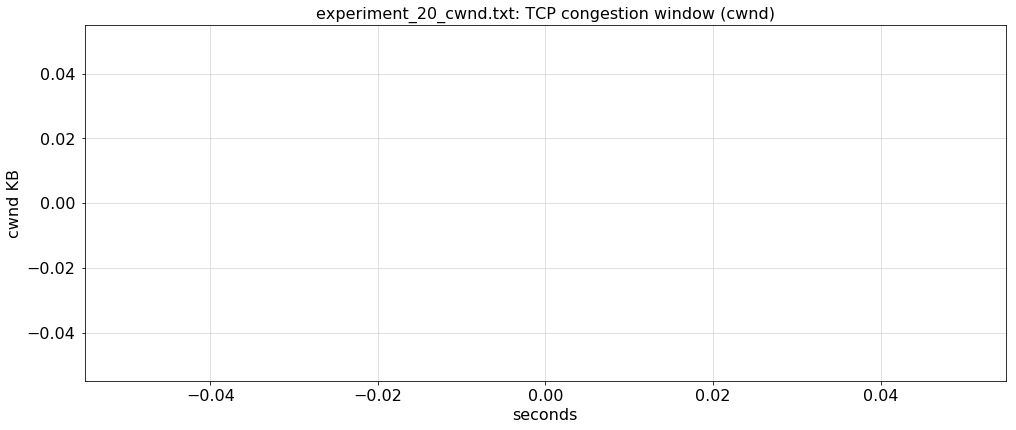

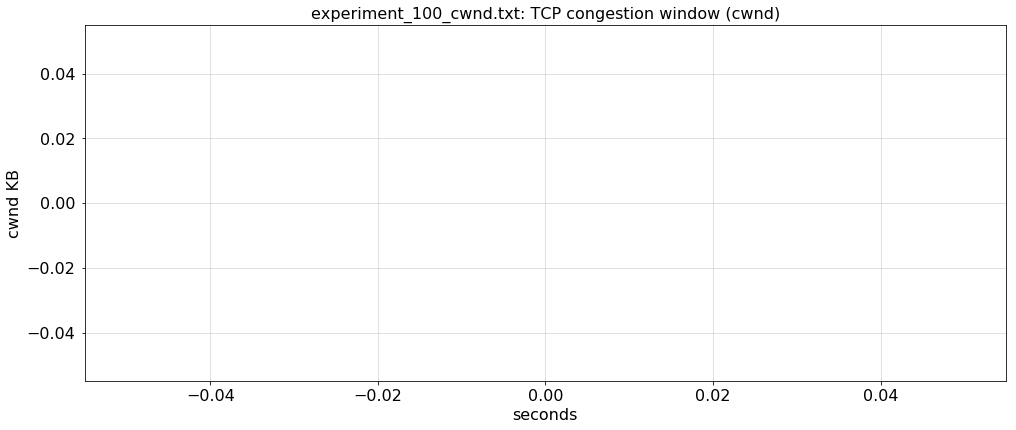

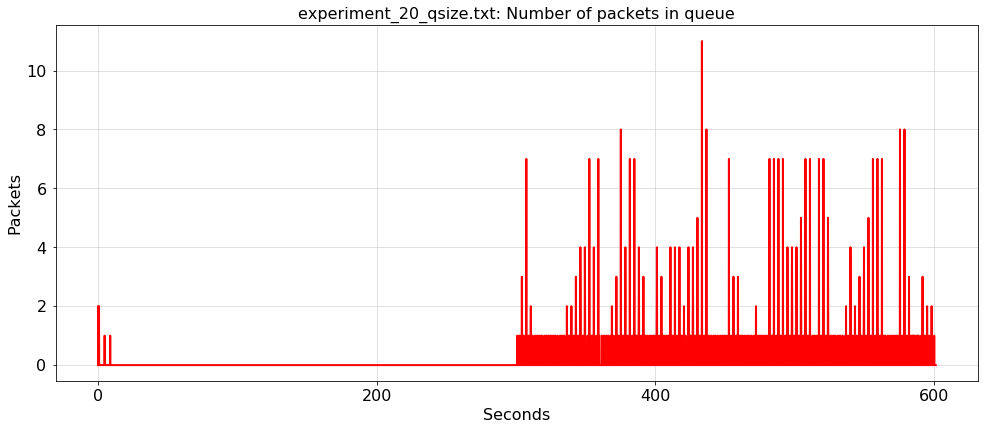

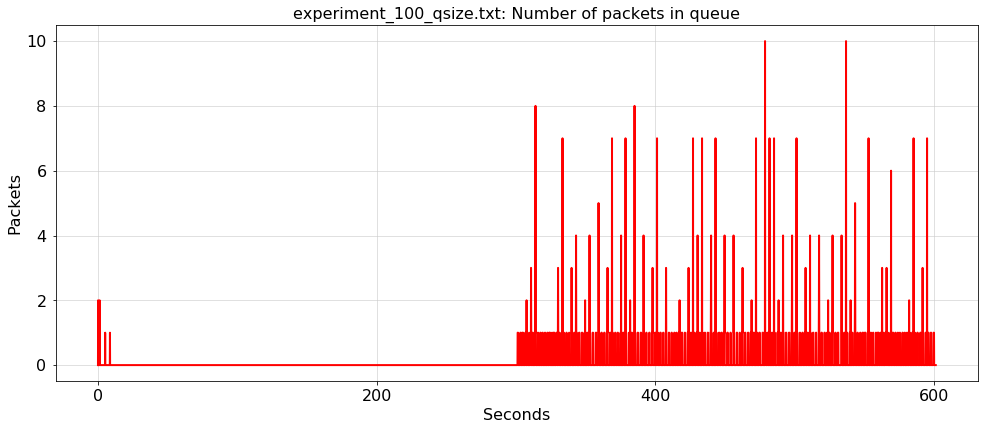

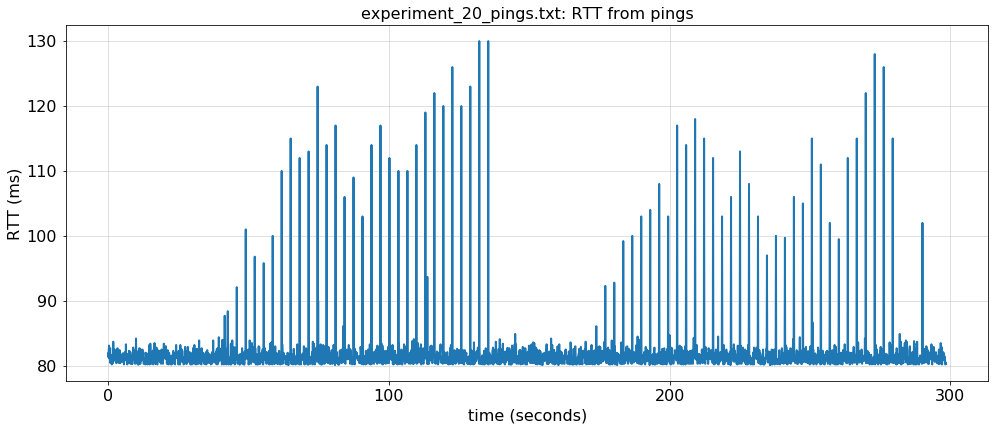

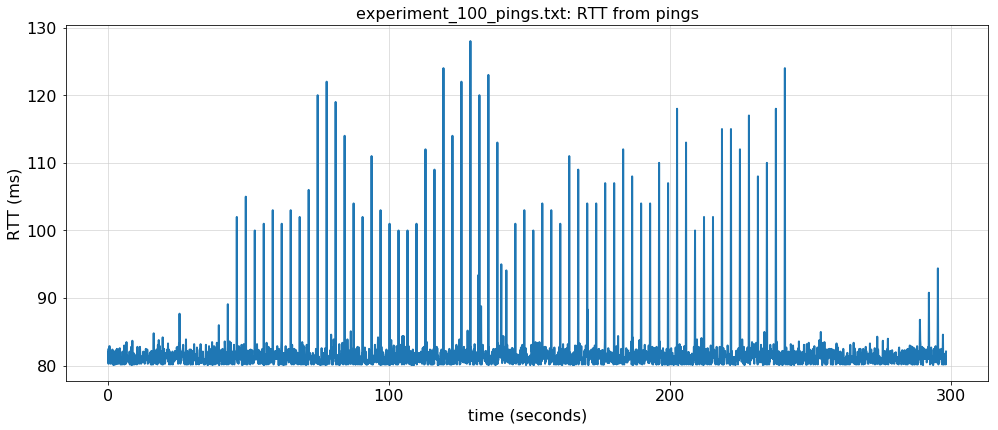

In [29]:
#TODO: Call plot_measurements() to plot your results
# Create a list of experiment names
experiment_name_list = ["experiment_20", "experiment_100"]

# Call plot_measurements() to plot the results
plot_measurements(experiment_name_list, cwnd_histogram=False)